In [1]:
from inference.snpe.snpe_c import SNPE_C as SNPE
from inference.base import *

import utils as utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch import nn
import seaborn as sns
import random
import pickle
import io
import utils.corruption as corruption
import utils.metrics as metrics
import copy
from simulators.ricker import ricker
from utils.corruption import sparsity, magnitude, magnitude_sigma
from networks.summary_nets import RickerSummary

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net.pkl".format(root_name=root_name), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator.pkl".format(root_name=root_name), map_location=device)

    with open("{root_name}/posterior.pkl".format(root_name=root_name), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
#     with open("{root_name}/inference.pkl".format(root_name=root_name), "rb") as handle:
#         inference = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior

In [4]:
def read_rnpe(model="ricker", misspecified=0, seed=1, theta=[4,10]):
    file = f"seed={seed}_var={misspecified}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}/"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])

In [5]:
def read_rnpe_pm(model="ricker_pm", seed=1, theta=[4,10]):
    file = f"seed={seed}_theta={theta}_{model}"

    results_dir = f"objects/rnpe/{model}/"
    fn = f"{results_dir}/{file}.pickle"

    with open(fn, "rb") as f:
        results = pickle.load(f)

    return np.array(results['posterior_samples']['RNPE'])

In [5]:
x = torch.tensor(np.load("data/ricker_x_4000.npy")).reshape(-1, 100, 100).to(device)
theta = np.load("data/ricker_theta_4000.npy")

# beta sensitivity

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

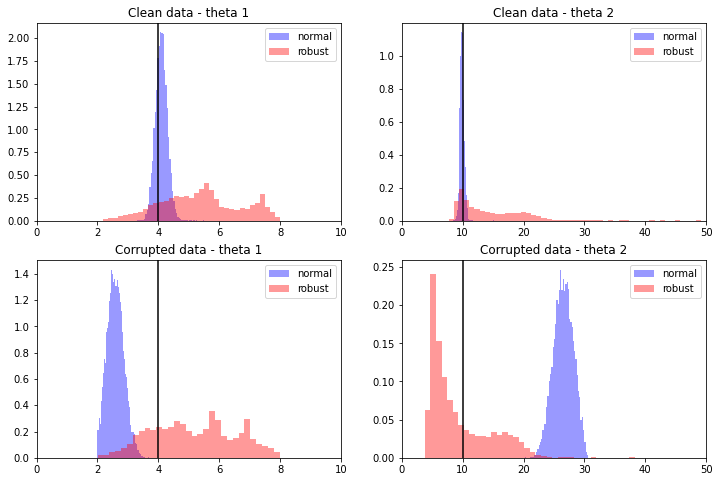

In [186]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=40.0_mmd_beta=1.0_theta=[4, 10]_num=1000/4"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/old/none_beta=1.0/7"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))


plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 10)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")

plt.legend()
plt.xlim(0, 50)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")

plt.legend()
plt.xlim(0, 10)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")

plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()



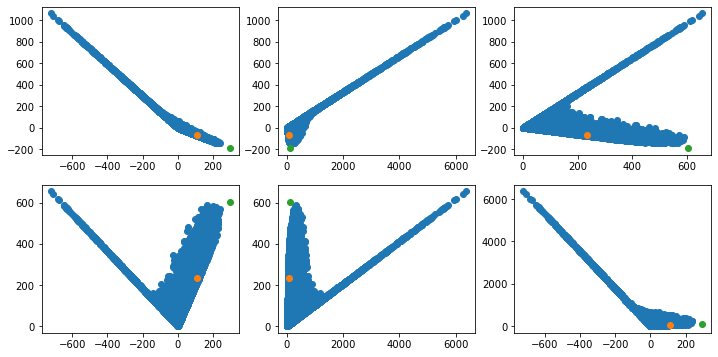

In [94]:
sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs)[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont)[1].detach().numpy()
x_summary = sum_net_normal_0(x)[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])
plt.show()

# prior mismatch case

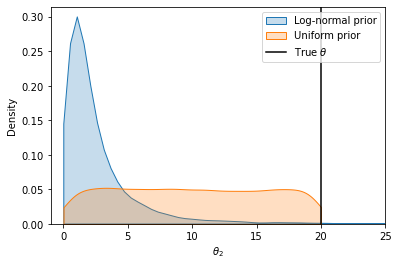

In [56]:
from scipy.stats import lognorm, uniform
stddev = 1
mean = 0.5
# dist=lognorm([stddev],loc=mean)
# x=np.linspace(0,30,10000)
# sns.lineplot(x, dist.pdf(x))

# dist2 = uniform(0, 20)
# x=np.linspace(0,20,10000)
# sns.lineplot(x, dist2.pdf(x))

prior = torch.distributions.log_normal.LogNormal(loc=torch.tensor([0.5]), scale=torch.tensor([1]))
prior_old = torch.distributions.uniform.Uniform(0, 20)

sns.kdeplot(prior.sample([10000]).reshape(-1), shade=True, cut=0, label="Log-normal prior")
sns.kdeplot(prior_old.sample([10000]).reshape(-1), shade=True, cut=0, label="Uniform prior")

plt.axvline(x=20,ls="-",c="black", label="True $\\theta$")
plt.xlim(-1, 25)
plt.legend(loc=1)
plt.xlabel("$\\theta_2$")
plt.savefig("prior_mismatch.pdf")
# plt.show()


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

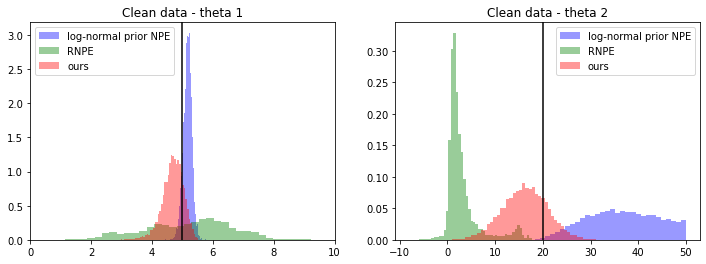

In [58]:
theta_gt = torch.tensor([5, 20])
obs = ricker(theta_gt).to(device)

theta_cont = torch.tensor([5, 20])
# obs_cont = ricker(theta_cont).to(device)
obs_cont = torch.tensor(np.load("data/ricker_obs_pm.npy"))

# 2 3 16
root_name = "objects/ricker/prior_mismatch/mmd_beta=2.0_theta=[5, 25]_num=1000_logn_sameobs/3"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/prior_mismatch/none_theta=[4, 10]_num=1000_lognormal/2"
sum_net_logn, density_estimator_logn, posterior_logn = load_models(root_name, device)

post_samples_logn_cont = posterior_logn.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_rnpe_cont = read_rnpe_pm(model="ricker_pm",seed=14, theta='[4,10]')

np.save("post_samples_normal.npy", post_samples_logn_cont.detach().numpy())
np.save("post_samples_robust.npy", post_samples_robust_cont.detach().numpy())
np.save("post_samples_rnpe.npy", post_samples_rnpe_cont)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.axvline(x=theta_cont[0],ls="-",c="black")
sns.distplot(post_samples_logn_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="log-normal prior NPE")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="ours")
plt.legend()
plt.xlim(0, 10)
plt.title("Clean data - theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_cont[1],ls="-",c="black")
sns.distplot(post_samples_logn_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="log-normal prior NPE")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="ours")
plt.legend()
# plt.xlim(0, 50)
plt.title("Clean data - theta 2")

plt.show()


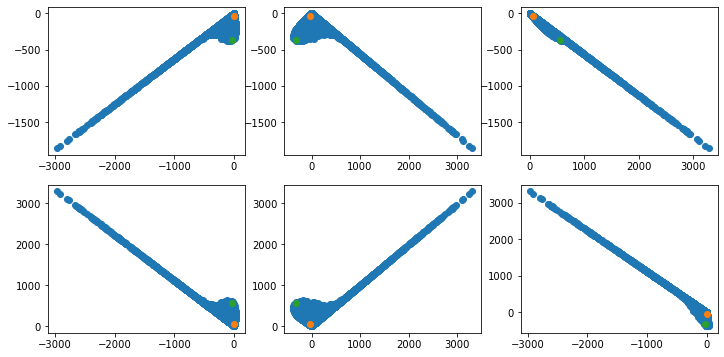

In [50]:
theta_gt = torch.tensor([5, 2])
obs = ricker(theta_gt).to(device)
theta_gt = torch.tensor([5, 20])
obs_cont = ricker(theta_gt).to(device)

sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs)[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont)[1].detach().numpy()
x_summary = sum_net_normal_0(x)[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])
plt.show()

# theta=[4, 10]

## var = 0

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


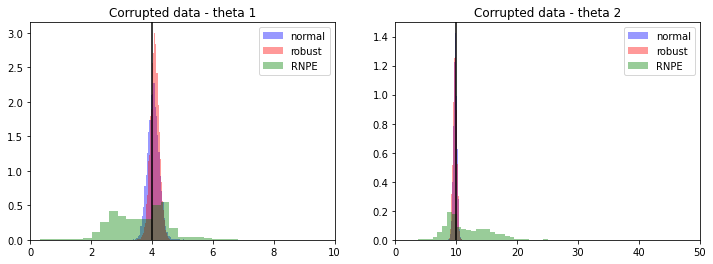

In [6]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([0])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=0.0_mmd_beta=1.0_theta=[4, 10]_num=1000/3"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/npe_num=1000/8"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_rnpe_cont = read_rnpe(model="ricker", misspecified=0, seed=1, theta='[4,10]')


# np.save("post_samples_normal_var=0.npy", post_samples_normal_cont.detach().numpy())
# np.save("post_samples_robust_var=0.npy", post_samples_robust_cont.detach().numpy())
# np.save("post_samples_rnpe_var=0.npy", post_samples_rnpe_cont)


plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 10)
plt.title("Corrupted data - theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

1.8201640129089356
3.47729115486145
1.0970697969198226


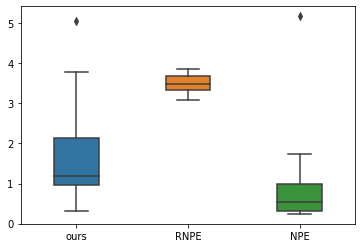

In [461]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([0])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 11):
    root_name = f"objects/ricker/var=0.0_mmd_beta=2.0_theta=[4, 10]_num=1000/{i}"
    _, _, posterior_robust = load_models(root_name, device)
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_robust = posterior_robust.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    thetas_npe = posterior_normal.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=0, seed=i, theta='[4,10]'))[:1000]
    
    dist_ours.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_robust, p=2).mean()))
    dist_rnpe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_rnpe, p=2).mean()))
    dist_npe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_npe, p=2).mean()))

x = 10 * ["ours"] + 10*["RNPE"] + 10 * ["NPE"] 
y = np.array([dist_ours, dist_rnpe, dist_npe]).reshape(-1)

sns.boxplot(x=x, y=y, width=0.4)

print(sum(dist_ours)/10)
print(sum(dist_rnpe)/10)
print(sum(dist_npe)/10)

## var = 20

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

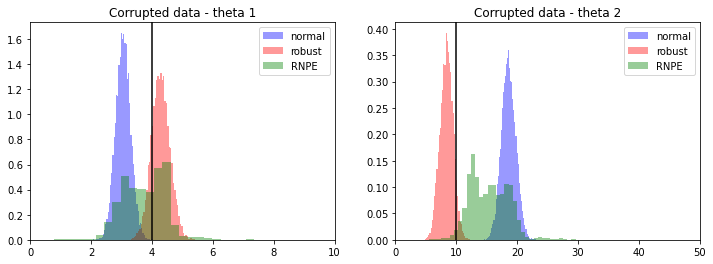

In [13]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([20])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=20.0_mmd_beta=2.0_theta=[4, 10]_num=1000/3"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/npe_num=1000/8"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_rnpe_cont = read_rnpe(model="ricker", misspecified=20, seed=1, theta='[4,10]')


np.save("post_samples_normal_var=20.npy", post_samples_normal_cont.detach().numpy())
np.save("post_samples_robust_var=20.npy", post_samples_robust_cont.detach().numpy())
np.save("post_samples_rnpe_var=20.npy", post_samples_rnpe_cont)


plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 10)
plt.title("Corrupted data - theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

3.0824951231479645
5.21665472984314
8.284761381149291


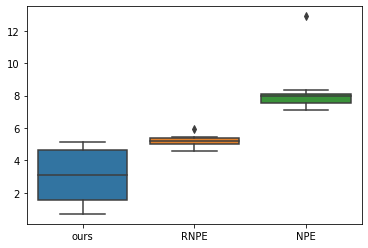

In [507]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([20])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 11):
    root_name = f"objects/ricker/var=20.0_mmd_beta=2.0_theta=[4, 10]_num=1000/{i}"
    _, _, posterior_robust = load_models(root_name, device)
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_robust = posterior_robust.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    thetas_npe = posterior_normal.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=20, seed=i, theta='[4,10]'))[:1000]
    
    dist_ours.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_robust, p=2).mean()))
    dist_rnpe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_rnpe, p=2).mean()))
    dist_npe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_npe, p=2).mean()))

x = 10 * ["ours"] + 10*["RNPE"] + 10 * ["NPE"] 
y = np.array([dist_ours, dist_rnpe, dist_npe]).reshape(-1)

sns.boxplot(x=x, y=y)

print(sum(dist_ours)/10)
print(sum(dist_rnpe)/10)
print(sum(dist_npe)/10)

In [494]:
thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=20, seed=3, theta='[4,10]'))[:10000]
print(torch.nn.functional.pairwise_distance(theta_gt, thetas_rnpe, p=2).mean())

tensor(5.1355)


## var = 40

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

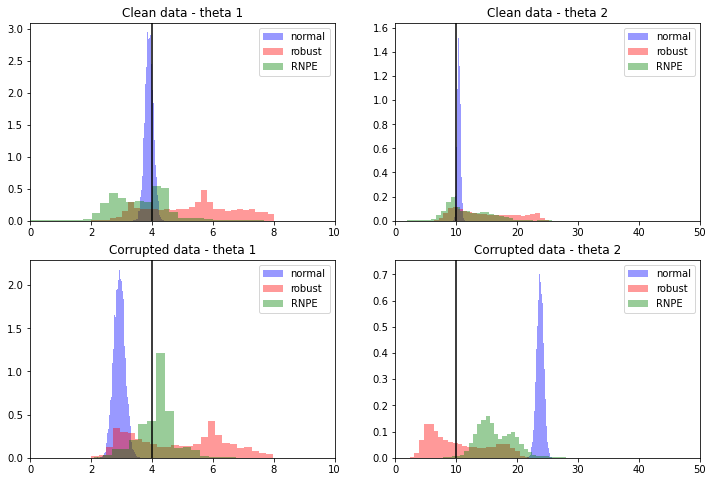

In [481]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=40.0_mmd_beta=1.0_theta=[4, 10]_num=1000/2"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/npe_num=1000/3"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_rnpe_clean = read_rnpe(model="ricker", misspecified=0, seed=1, theta='[4,10]')
post_samples_rnpe_cont = read_rnpe(model="ricker", misspecified=40, seed=1, theta='[4,10]')

# np.save("obs.npy", obs.detach().numpy())
# np.save("obs_cont_var=40.npy", obs_cont.detach().numpy())

# np.save("post_samples_normal_var=0.npy", post_samples_normal_clean.detach().numpy())
# np.save("post_samples_robust_var=0.npy", post_samples_robust_clean.detach().numpy())
# np.save("post_samples_rnpe_var=0.npy", post_samples_rnpe_clean)

# np.save("post_samples_normal_var=40.npy", post_samples_normal_cont.detach().numpy())
# np.save("post_samples_robust_var=40.npy", post_samples_robust_cont.detach().numpy())
# np.save("post_samples_rnpe_var=40.npy", post_samples_rnpe_cont)


plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_clean[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 10)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_clean[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 10)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

6.280263495445252
7.136736631393433
14.557931423187256


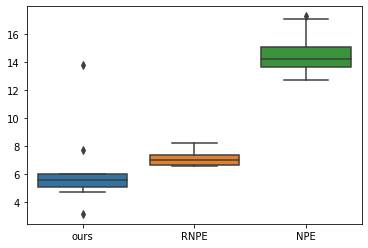

In [478]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 11):
    root_name = f"objects/ricker/var=40.0_mmd_beta=2.0_theta=[4, 10]_num=1000/{i}"
    _, _, posterior_robust = load_models(root_name, device)
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_robust = posterior_robust.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    thetas_npe = posterior_normal.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=40, seed=i, theta='[4,10]'))[:1000]
    
    dist_ours.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_robust, p=2).mean()))
    dist_rnpe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_rnpe, p=2).mean()))
    dist_npe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_npe, p=2).mean()))

x = 10 * ["ours"] + 10*["RNPE"] + 10 * ["NPE"] 
y = np.array([dist_ours, dist_rnpe, dist_npe]).reshape(-1)

sns.boxplot(x=x, y=y)

print(sum(dist_ours)/10)
print(sum(dist_rnpe)/10)
print(sum(dist_npe)/10)

In [435]:
thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=40, seed=1, theta='[4,10]'))[:10000]
print(torch.nn.functional.pairwise_distance(theta_gt, thetas_rnpe, p=2).mean())

tensor(6.5446)


## var = 80

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

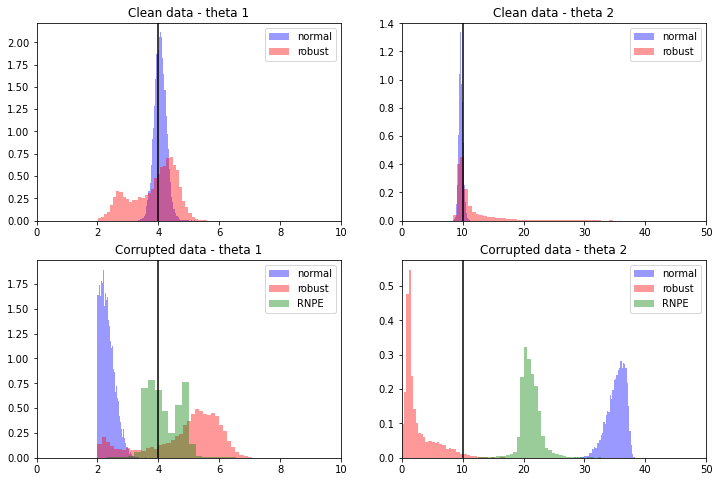

In [398]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([80])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=80.0_mmd_beta=3.0_theta=[4, 10]_num=1000/3"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/old/npe_num=1000/7"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
# post_samples_rnpe_clean = read_rnpe(misspecified=0, seed=1, theta='[4,10]')
post_samples_rnpe_cont = read_rnpe(model="ricker", misspecified=80, seed=9, theta='[4,10]')

# np.save("post_samples_normal_var=80.npy", post_samples_normal_cont.detach().numpy())
# np.save("post_samples_robust_var=80.npy", post_samples_robust_cont.detach().numpy())
# np.save("post_samples_rnpe_var=80.npy", post_samples_rnpe_cont)

plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
# sns.distplot(post_samples_rnpe_clean[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 10)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
# sns.distplot(post_samples_rnpe_clean[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 10)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

['ours', 'ours', 'ours', 'ours', 'ours', 'ours', 'ours', 'ours', 'ours', 'ours', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'RNPE', 'NPE', 'NPE', 'NPE', 'NPE', 'NPE', 'NPE', 'NPE', 'NPE', 'NPE', 'NPE']
11.909132766723634
10.196866416931153
19.547546100616454


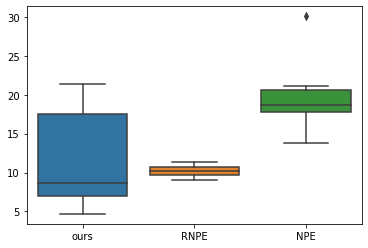

In [452]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([80])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

dist_ours = []
dist_npe = []
dist_rnpe = []
for i in range(1, 11):
    root_name = f"objects/ricker/var=80.0_mmd_beta=3.0_theta=[4, 10]_num=1000/{i}"
    _, _, posterior_robust = load_models(root_name, device)
    
    root_name = f"objects/ricker/npe_num=1000/{i}"
    _, _, posterior_normal = load_models(root_name, device)
    
    thetas_robust = posterior_robust.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    thetas_npe = posterior_normal.sample((1000,), x=obs_cont.reshape(1, 1, 100, 100))
    
    thetas_rnpe = torch.tensor(read_rnpe(model="ricker", misspecified=80, seed=i, theta='[4,10]'))[:1000]
    
    dist_ours.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_robust, p=2).mean()))
    dist_rnpe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_rnpe, p=2).mean()))
    dist_npe.append(float(torch.nn.functional.pairwise_distance(theta_gt, thetas_npe, p=2).mean()))

x = 10 * ["ours"] + 10 * ["RNPE"] + 10*["NPE"]
print(x)
y = np.array([dist_ours, dist_rnpe, dist_npe]).reshape(-1)

sns.boxplot(x=x, y=y)

print(sum(dist_ours)/10)
print(sum(dist_rnpe)/10)
print(sum(dist_npe)/10)

# theta=[5, 7]

In [297]:
theta_gt = torch.tensor([5, 7])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([80])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=80_mmd_beta=2.0_theta=[5,7]/4"
sum_net_robust, density_estimator_robust, posterior_robust = load_models("normal", root_name, device, r=0)

root_name = "objects/ricker/var=15_none_beta=1.0/7"
sum_net_normal, density_estimator_normal, posterior_normal = load_models("normal", root_name, device, r=0)

post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_rnpe_clean = read_rnpe(misspecified=0, seed=1, theta='[5,7]')
post_samples_rnpe_cont = read_rnpe(misspecified=80, seed=1, theta='[5,7]')

plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_clean[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(2, 8)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_clean[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 20)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(2, 8)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()


TypeError: load_models() got an unexpected keyword argument 'r'

# theta=[3, 8]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

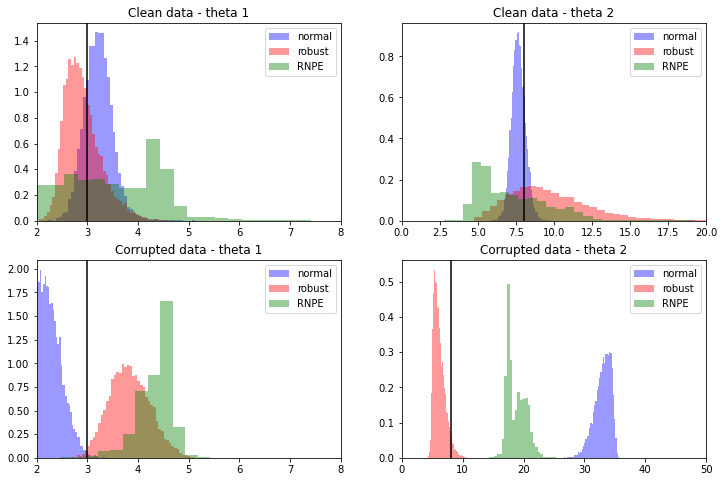

In [84]:
theta_gt = torch.tensor([3, 8])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([80])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=80_mmd_beta=2.0_theta=[3,8]/5"
sum_net_robust, density_estimator_robust, posterior_robust = load_models("normal", root_name, device, r=0)

root_name = "objects/ricker/var=15_none_beta=1.0/7"
sum_net_normal, density_estimator_normal, posterior_normal = load_models("normal", root_name, device, r=0)

post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_rnpe_clean = read_rnpe(misspecified=0, seed=1, theta='[3,8]')
post_samples_rnpe_cont = read_rnpe(misspecified=80, seed=1, theta='[3,8]')

plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_clean[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(2, 8)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_clean[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 20)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(2, 8)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
sns.distplot(post_samples_rnpe_cont[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
plt.legend()
plt.xlim(0, 50)
plt.title("Corrupted data - theta 2")
plt.show()


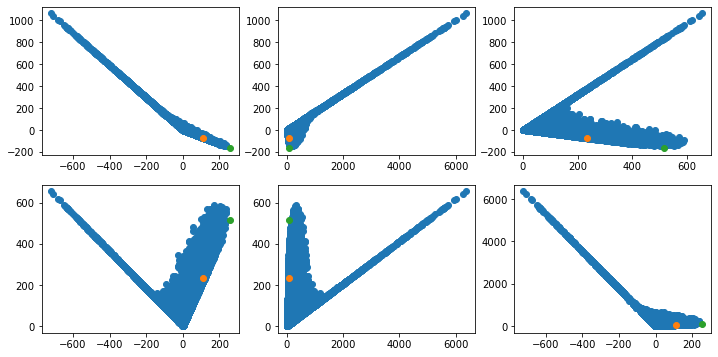

In [64]:
sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs)[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont)[1].detach().numpy()
x_summary = sum_net_normal_0(x)[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])
plt.show()

In [7]:
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

root_name = "objects/ricker/var=40.0_mmd_beta=1.0_theta=[4, 10]_num=1000/1"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/ricker/old/npe_num=1000/7"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_cont_summary_normal = sum_net_normal_0(obs_cont)[1].detach().numpy()
obs_summary_normal = sum_net_normal_0(obs)[1].detach().numpy()
x_summary_normal = sum_net_normal_0(x)[1].detach().numpy()

sum_net_normal_0 = copy.deepcopy(sum_net_robust)

obs_cont_summary_robust = sum_net_normal_0(obs_cont)[1].detach().numpy()
x_summary_robust = sum_net_normal_0(x)[1].detach().numpy()

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_normal = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))

# np.save("obs.npy", obs.detach().numpy())
# np.save("obs_cont.npy", obs_cont.detach().numpy())
# np.save("x_summary_normal.npy", x_summary_normal)
# np.save("obs_cont_summary_normal.npy", obs_cont_summary_normal)
# np.save("x_summary_robust.npy", x_summary_robust)
# np.save("obs_cont_summary_robust.npy", obs_cont_summary_robust)
# np.save("post_samples_normal_cont.npy", post_samples_normal_cont.detach().numpy())
# np.save("post_samples_robust_cont.npy", post_samples_robust_cont.detach().numpy())

np.save("obs_summary_normal.npy", obs_summary_normal)
np.save("post_samples_normal.npy", post_samples_normal.detach().numpy())

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/huangd5/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


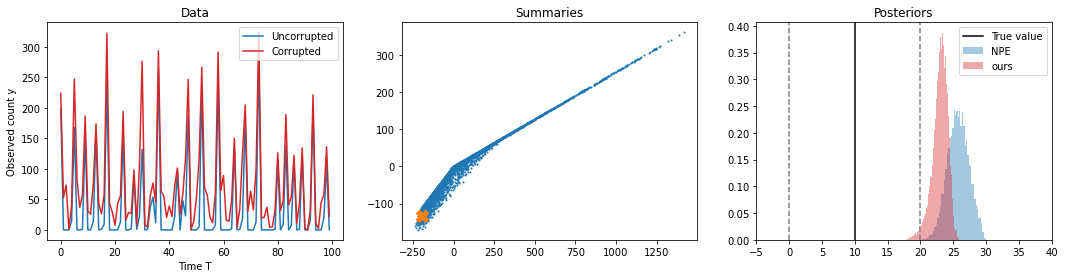

In [45]:
# theta_gt = torch.tensor([4, 10])
# obs = ricker(theta_gt).to(device)
# sigma = torch.tensor([1])
# obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)

# root_name = "objects/ricker/var=100_mmd_beta=2.0_theta=[4,10]/2"
# sum_net_robust, density_estimator_robust, posterior_robust = load_models("normal", root_name, device, r=0)

# root_name = "objects/ricker/old/var=15_none_beta=1.0/7"
# sum_net_normal, density_estimator_normal, posterior_normal = load_models("normal", root_name, device, r=0)

sum_net_normal_0 = copy.deepcopy(sum_net_robust)

obs_summary = sum_net_normal_0(obs)[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont)[1].detach().numpy()
x_summary = sum_net_normal_0(x)[1].detach().numpy()

post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))

figure = plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(range(100), obs[2], color='tab:blue', label="Uncorrupted")
plt.plot(range(100), obs_cont[0, 2], color="tab:red", label="Corrupted")
plt.legend(loc=1)
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.title("Data")


plt.subplot(1, 3, 2)
plt.scatter(x_summary[:, 0], x_summary[:, 1], s=1, color='tab:blue')
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2], s=150, marker='X',color="tab:orange")
plt.title("Summaries")

plt.subplot(1, 3, 3)
plt.axvline(x=theta_gt[1],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='tab:blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='tab:red', kde=False, norm_hist=True, label="ours")
plt.legend(loc=1)
plt.xlim(-5, 40)
plt.axvline(x=0,ls="--",c="grey")
plt.axvline(x=20,ls="--",c="grey")
plt.title("Posteriors")

plt.show()

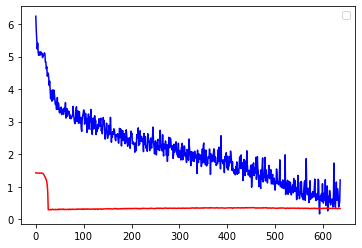

In [272]:
root_name = "objects/magnitude_Gaussian_degree=1.0_var=15_mmd_beta=2.0_theta57/3"
with open("{root_name}/train_losses_0.pkl".format(root_name=root_name), "rb") as handle:
    train_losses = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
with open("{root_name}/summary_losses_0.pkl".format(root_name=root_name), "rb") as handle:
    summary_losses = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)

plt.plot(range(len(train_losses)), train_losses, color="blue")
plt.plot(range(len(train_losses)), summary_losses, color="red")
plt.legend()

In [8]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

MMD_unweighted(sum_net_normal(x)[1], sum_net_normal(obs_cont)[1], lengthscale=median_heuristic(sum_net_normal(x)[1]))

tensor(1.2587, grad_fn=<AddBackward0>)

In [167]:
# read robust part
root_name = "objects/magnitude_Gaussian_2_degree=1.0_var=15_obs_minimize_beta=1.0/1"

# posterior_robust = load_models("robust", root_name, device)
sum_net_normal_0, density_estimator_normal_0, posterior_normal_0 = load_models("normal", root_name, device, r=0)
sum_net_normal_1, density_estimator_normal_1, posterior_normal_1 = load_models("normal", root_name, device, r=1)
sum_net_normal_2, density_estimator_normal_2, posterior_normal_2 = load_models("normal", root_name, device, r=2)
sum_net_normal_3, density_estimator_normal_3, posterior_normal_3 = load_models("normal", root_name, device, r=3)
sum_net_robust_0, density_estimator_robust_0, posterior_robust_0 = load_models("robust", root_name, device, r=0)
sum_net_robust_1, density_estimator_robust_1, posterior_robust_1 = load_models("robust", root_name, device, r=1)
sum_net_robust_2, density_estimator_robust_2, posterior_robust_2 = load_models("robust", root_name, device, r=2)
sum_net_robust_3, density_estimator_robust_3, posterior_robust_3 = load_models("robust", root_name, device, r=3)

(4000, 2)


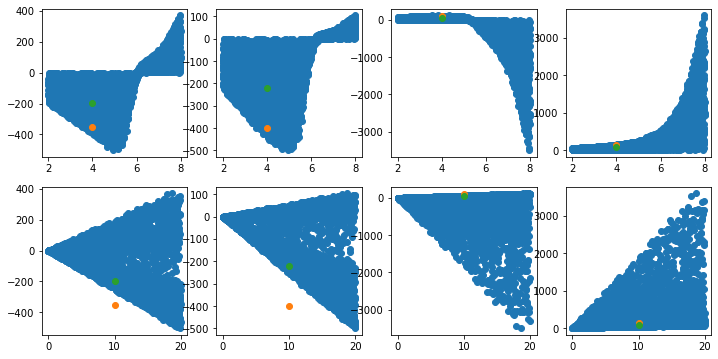

In [251]:
# obs_cont = torch.tensor(np.load("data/x_o_cont.npy"))
theta_gt = torch.tensor([4, 10])
obs = ricker(theta_gt).to(device)
sigma = torch.tensor([40])
obs_cont = corruption.magnitude_sigma(obs, var=sigma).reshape(-1, 100, 100)
obs_summary = sum_net_normal_0(obs)[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont)[1].detach().numpy()

x = torch.tensor(np.load("data/x.npy")).reshape(-1, 100, 100).to(device)
theta = np.load("data/theta.npy")
print(theta.shape)
x_summary = sum_net_normal_0(x)[1].detach().numpy()


plt.figure(figsize=(12,6))
plt.subplot(2, 4, 1)
plt.scatter(theta[:, 0], x_summary[:, 0])
plt.scatter(4, obs_cont_summary[0, 0])
plt.scatter(4, obs_summary[0, 0])

plt.subplot(2, 4, 2)
plt.scatter(theta[:, 0], x_summary[:, 1])
plt.scatter(4, obs_cont_summary[0, 1])
plt.scatter(4, obs_summary[0, 1])

plt.subplot(2, 4, 3)
plt.scatter(theta[:, 0], x_summary[:, 2])
plt.scatter(4, obs_cont_summary[0, 2])
plt.scatter(4, obs_summary[0, 2])

plt.subplot(2, 4, 4)
plt.scatter(theta[:, 0], x_summary[:, 3])
plt.scatter(4, obs_cont_summary[0, 3])
plt.scatter(4, obs_summary[0, 3])

plt.subplot(2, 4, 5)
plt.scatter(theta[:, 1], x_summary[:, 0])
plt.scatter(10, obs_cont_summary[0, 0])
plt.scatter(10, obs_summary[0, 0])

plt.subplot(2, 4, 6)
plt.scatter(theta[:, 1], x_summary[:, 1])
plt.scatter(10, obs_cont_summary[0, 1])
plt.scatter(10, obs_summary[0, 1])

plt.subplot(2, 4, 7)
plt.scatter(theta[:, 1], x_summary[:, 2])
plt.scatter(10, obs_cont_summary[0, 2])
plt.scatter(10, obs_summary[0, 2])

plt.subplot(2, 4, 8)
plt.scatter(theta[:, 1], x_summary[:, 3])
plt.scatter(10, obs_cont_summary[0, 3])
plt.scatter(10, obs_summary[0, 3])

plt.show()

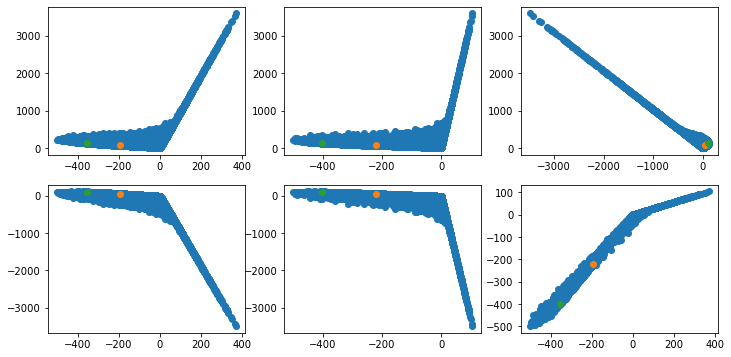

In [252]:
plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])


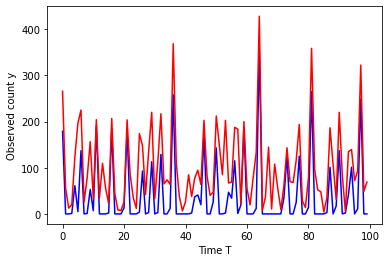

In [11]:
plt.plot(range(100), obs[2], color="blue")
plt.plot(range(100), obs_cont[0, 2], color="red")
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 100 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


<AxesSubplot:>

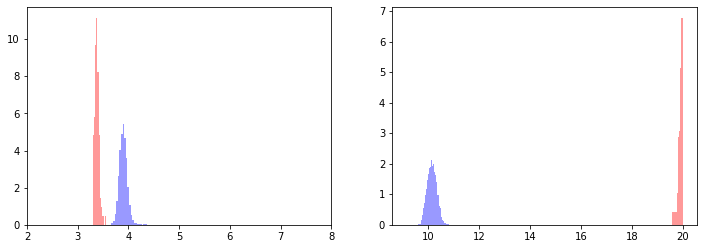

In [255]:
post_samples_normal = posterior_normal_3.sample((10000,), x=obs.reshape(1, 1, 100, 100))
post_samples_cont = posterior_normal_3.sample((100,), x=obs_cont.reshape(1, 1, 100, 100))

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")

plt.subplot(1, 2, 2)
# plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

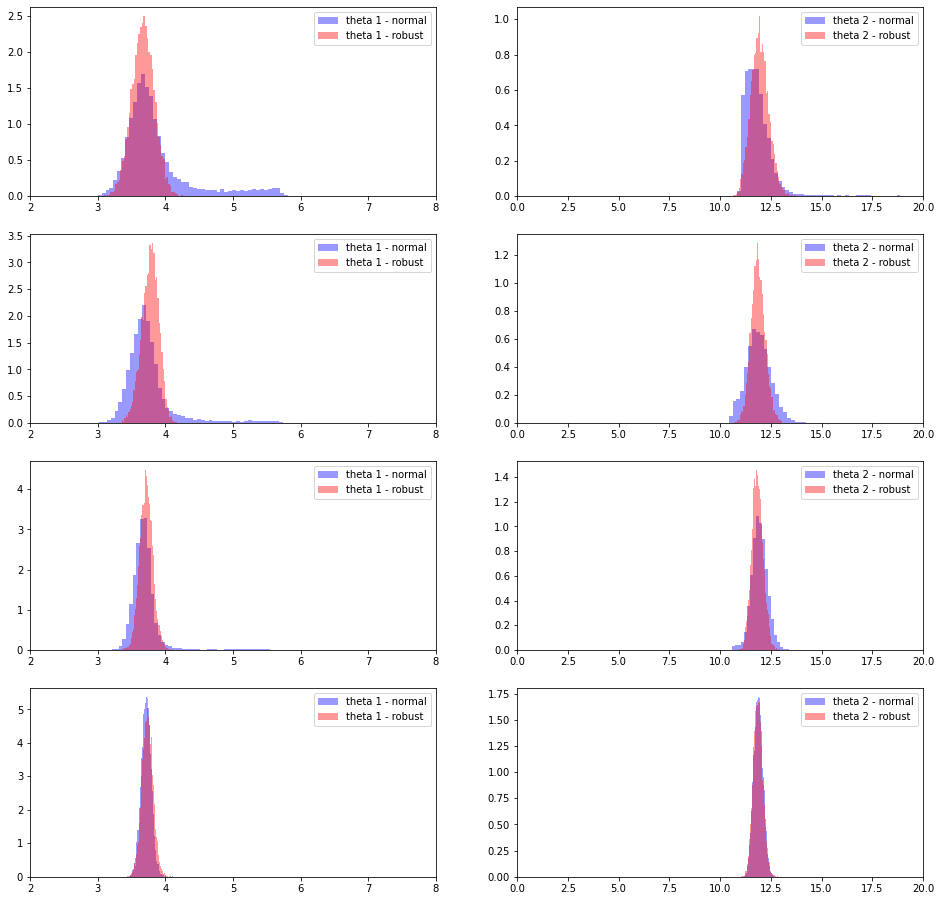

In [163]:
theta_gt = torch.tensor([4, 10])

obs = ricker(theta_gt).to(device)
obs_cont = magnitude_sigma(obs, var=5)
post_samples_normal_0 = posterior_normal_0.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_normal_1 = posterior_normal_1.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_normal_2 = posterior_normal_2.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_normal_3 = posterior_normal_3.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_0 = posterior_robust_0.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_1 = posterior_robust_1.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_2 = posterior_robust_2.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust_3 = posterior_robust_3.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
# post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))

plt.figure(figsize=(16,16))

plt.subplot(4, 2, 1)
plt.xlim(2, 8)
sns.distplot(post_samples_normal_0[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_robust_0[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
# sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(4, 2, 2)
plt.xlim(0, 20)
sns.distplot(post_samples_normal_0[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
sns.distplot(post_samples_robust_0[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
# sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.subplot(4, 2, 3)
plt.xlim(2, 8)
sns.distplot(post_samples_normal_1[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_robust_1[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(4, 2, 4)
plt.xlim(0, 20)
sns.distplot(post_samples_normal_1[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
sns.distplot(post_samples_robust_1[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.subplot(4, 2, 5)
plt.xlim(2, 8)
sns.distplot(post_samples_normal_2[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_robust_2[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(4, 2, 6)
plt.xlim(0, 20)
sns.distplot(post_samples_normal_2[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
sns.distplot(post_samples_robust_2[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.subplot(4, 2, 7)
plt.xlim(2, 8)
sns.distplot(post_samples_normal_3[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
sns.distplot(post_samples_robust_3[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(4, 2, 8)
plt.xlim(0, 20)
sns.distplot(post_samples_normal_3[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
sns.distplot(post_samples_robust_3[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.show()

In [56]:
import utils.corruption as corruption
theta_gt = torch.tensor([4, 10])
x_o = ricker(theta_gt).to(device)
sigma = torch.tensor([5])
x_o_cont = corruption.magnitude_sigma(x_o, var=sigma).reshape(-1, 100, 100)
np.save("data/x_o_cont.npy", x_o_cont)

In [59]:
x_o_cont = torch.tensor(np.load("data/x_o_cont.npy"))
x_o_cont.shape

torch.Size([1, 100, 100])

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 2])


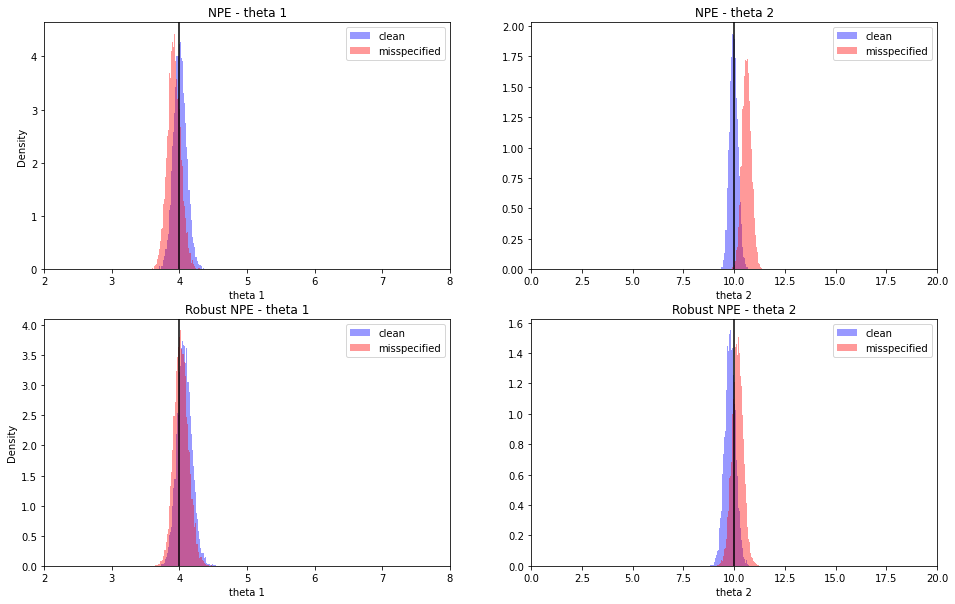

In [16]:
theta_gt = torch.tensor([[4, 10]])

obs = ricker(theta_gt).to(device)
obs_cont = magnitude_sigma(obs, var=2)

post_samples_normal = posterior_normal.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_cont_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs.reshape(1, 100, 100))
post_samples_cont_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 100, 100))
print(post_samples_robust.shape)

plt.figure(figsize=(16,10))
plt.subplot(2, 2, 1)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_normal[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.xlim(2, 8)
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("NPE - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(2, 2, 2)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_normal[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
plt.xlim(0, 20)
plt.xlabel("theta 2")
plt.title("NPE - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()

plt.subplot(2, 2, 3)
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
# sns.distplot(rnpe_posterior_samples[:, 0], color='yellow', kde=False, norm_hist=True, label="rnpe")
# sns.distplot(rnpe_posterior_samples_well[:, 0], color='green', kde=False, norm_hist=True, label="rnpe")
plt.xlim(2, 8)
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Robust NPE - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(2, 2, 4)
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="clean")
sns.distplot(post_samples_cont_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="misspecified")
# sns.distplot(rnpe_posterior_samples[:, 1], color='yellow', kde=False, norm_hist=True, label="rnpe")
# sns.distplot(rnpe_posterior_samples_well[:, 1], color='green', kde=False, norm_hist=True, label="rnpe")
plt.xlim(0, 20)
plt.xlabel("theta 2")
plt.title("Robust NPE - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")

plt.legend()
plt.show()

In [88]:
def magnitude(obs, degree=0.2, var=5):
    obs_cont = torch.clone(obs).to(obs.device)

    num_total = int(obs.shape[0])
    num_cont = int(num_total * degree)
    index_list = [int(i) for i in range(num_total)]
    random.shuffle(index_list)

    for i in range(num_cont):
        obs_cont[index_list[i]] += torch.abs(torch.randn(100).to(obs.device) * var)

    return obs_cont

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

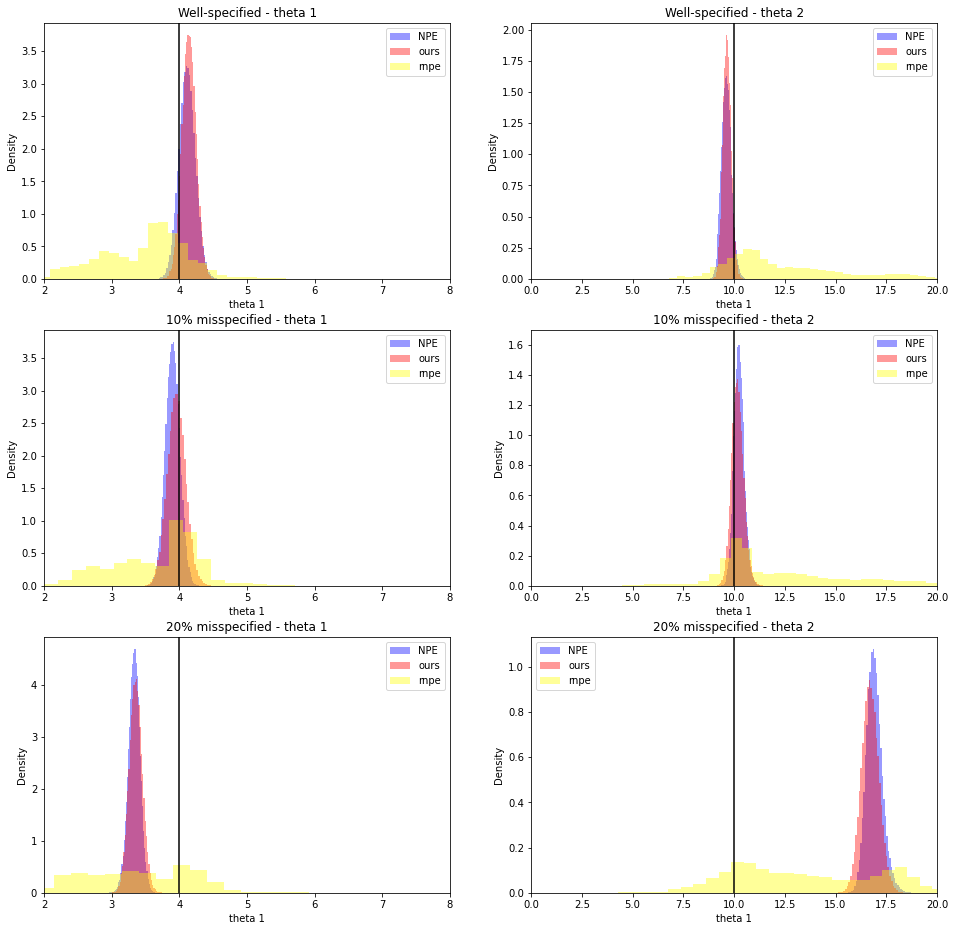

In [98]:
theta_gt = torch.tensor([[4, 10]])
degree = [0, 0.1, 0.2]


plt.figure(figsize=(16,16))

root_name = "objects/magnitude_degree={degree}_var=15_euclidean_beta=1".format(degree=str(degree[0]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=degree[0], var=0)

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((100000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((100000,), x=obs_cont.reshape(1, 100, 100))
post_samples_rnpe = read_rnpe(misspecified=degree[0], seed=2)

plt.subplot(3, 2, 1)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
sns.distplot(post_samples_rnpe[:, 0], color='yellow', kde=False, norm_hist=True, label="rnpe")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Well-specified - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 2)
plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
sns.distplot(post_samples_rnpe[:, 1], color='yellow', kde=False, norm_hist=True, label="rnpe")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Well-specified - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()


root_name = "objects/magnitude_degree={degree}_var=15_euclidean_beta=1".format(degree=str(degree[1]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=degree[1])

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((100000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((100000,), x=obs_cont.reshape(1, 100, 100))
post_samples_rnpe = read_rnpe(misspecified=degree[1], seed=4)

plt.subplot(3, 2, 3)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
sns.distplot(post_samples_rnpe[:, 0], color='yellow', kde=False, norm_hist=True, label="rnpe")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("10% misspecified - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 4)
plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
sns.distplot(post_samples_rnpe[:, 1], color='yellow', kde=False, norm_hist=True, label="rnpe")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("10% misspecified - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()


root_name = "objects/magnitude_degree={degree}_var=15_euclidean_beta=1.5".format(degree=str(degree[2]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=1, var=20)

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((100000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((100000,), x=obs_cont.reshape(1, 100, 100))
post_samples_rnpe = read_rnpe(misspecified=degree[2], seed=3)

plt.subplot(3, 2, 5)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
sns.distplot(post_samples_rnpe[:, 0], color='yellow', kde=False, norm_hist=True, label="rnpe")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified - theta 1")
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 6)
plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
sns.distplot(post_samples_rnpe[:, 1], color='yellow', kde=False, norm_hist=True, label="rnpe")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified - theta 2")
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()

plt.show()


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

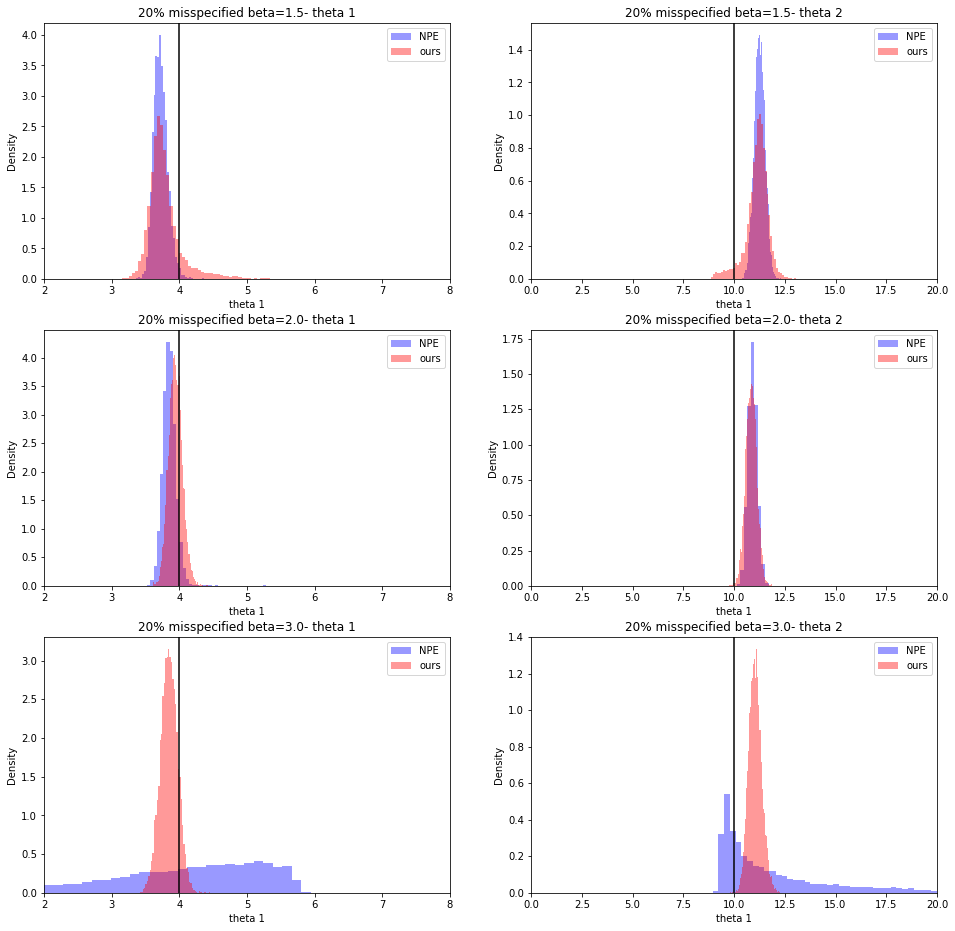

In [85]:
theta_gt = torch.tensor([[4, 10]])
beta = [1.5, 2.0, 3.0]


plt.figure(figsize=(16,16))

root_name = "objects/magnitude_degree=0.2_var=15_euclidean_beta={beta}/2".format(beta=str(beta[0]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=0.2)

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 100, 100))

plt.subplot(3, 2, 1)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 1".format(beta=beta[0]))
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 2)
plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 2".format(beta=beta[0]))
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()


root_name = "objects/magnitude_degree=0.2_var=15_euclidean_beta={beta}/9".format(beta=str(beta[1]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=0.2)

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 100, 100))

plt.subplot(3, 2, 3)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 1".format(beta=beta[1]))
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 4)
plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 2".format(beta=beta[1]))
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()


root_name = "objects/magnitude_degree=0.2_var=15_euclidean_beta={beta}/7".format(beta=str(beta[2]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=0.2)

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 100, 100))

plt.subplot(3, 2, 5)
plt.xlim(2, 8)
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 1".format(beta=beta[2]))
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 6)
plt.xlim(0, 20)
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 2".format(beta=beta[2]))
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()

plt.show()

# Comparison between mmd and euclidean

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

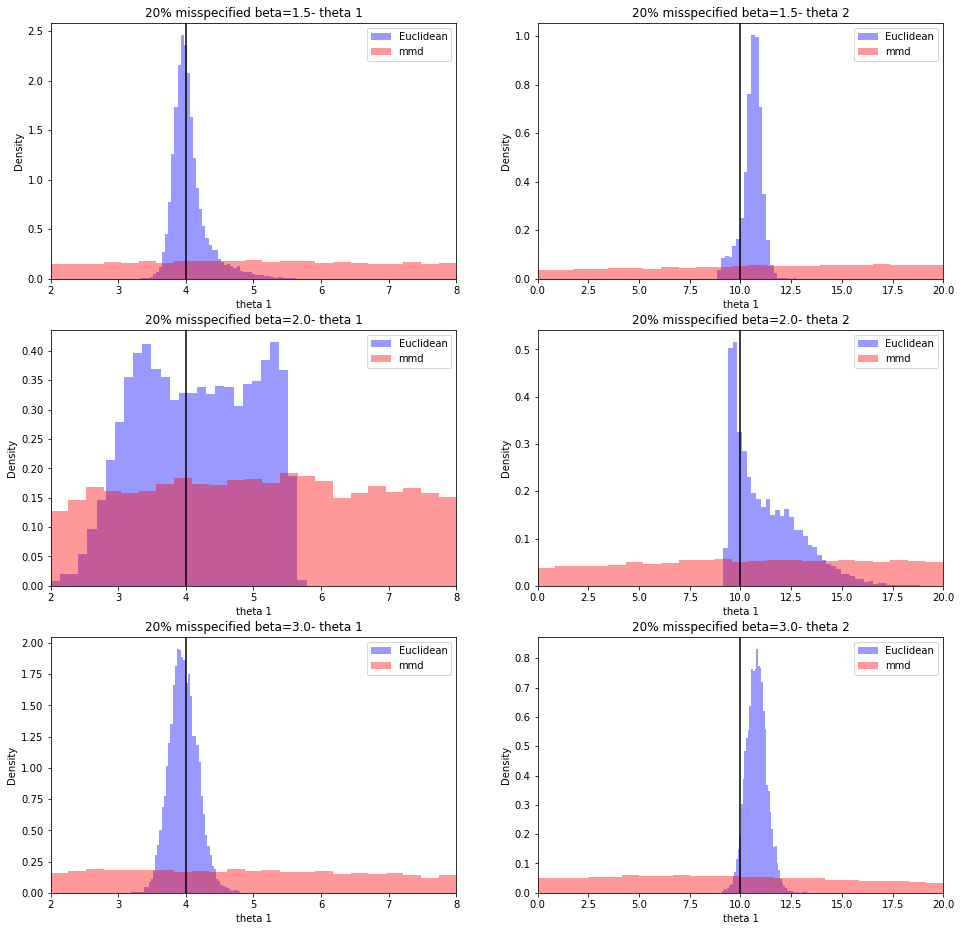

In [82]:
theta_gt = torch.tensor([[4, 10]])
beta = [1.5, 2.0, 3.0]


plt.figure(figsize=(16,16))

root_name_eu = "objects/magnitude_degree=0.2_var=15_euclidean_beta={beta}/2".format(beta=str(beta[0]))
root_name_mmd = "objects/magnitude_degree=0.2_var=15_mmd_beta={beta}/3".format(beta=str(beta[0]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=0.2)

sum_net_eu, _, posterior_eu = load_models("robust", root_name_eu, device)
sum_net_mmd, _, posterior_mmd = load_models("robust", root_name_mmd, device)
post_samples_eu = posterior_eu.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_mmd = posterior_mmd.sample((10000,), x=obs_cont.reshape(1, 100, 100))

plt.subplot(3, 2, 1)
plt.xlim(2, 8)
sns.distplot(post_samples_eu[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="Euclidean")
sns.distplot(post_samples_mmd[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="mmd")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 1".format(beta=beta[0]))
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 2)
plt.xlim(0, 20)
sns.distplot(post_samples_eu[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="Euclidean")
sns.distplot(post_samples_mmd[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="mmd")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 2".format(beta=beta[0]))
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()


root_name_eu = "objects/magnitude_degree=0.2_var=15_euclidean_beta={beta}/2".format(beta=str(beta[1]))
root_name_mmd = "objects/magnitude_degree=0.2_var=15_mmd_beta={beta}/2".format(beta=str(beta[1]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=0.2)

sum_net_eu, _, posterior_eu = load_models("robust", root_name_eu, device)
sum_net_mmd, _, posterior_mmd = load_models("robust", root_name_mmd, device)
post_samples_eu = posterior_eu.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_mmd = posterior_mmd.sample((10000,), x=obs_cont.reshape(1, 100, 100))

plt.subplot(3, 2, 3)
plt.xlim(2, 8)
sns.distplot(post_samples_eu[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="Euclidean")
sns.distplot(post_samples_mmd[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="mmd")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 1".format(beta=beta[1]))
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 4)
plt.xlim(0, 20)
sns.distplot(post_samples_eu[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="Euclidean")
sns.distplot(post_samples_mmd[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="mmd")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 2".format(beta=beta[1]))
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()


root_name_eu = "objects/magnitude_degree=0.2_var=15_euclidean_beta={beta}/5".format(beta=str(beta[2]))
root_name_mmd = "objects/magnitude_degree=0.2_var=15_mmd_beta={beta}/9".format(beta=str(beta[2]))

obs = ricker(theta_gt).to(device)
obs_cont = magnitude(obs, degree=0.2)

sum_net_eu, _, posterior_eu = load_models("robust", root_name_eu, device)
sum_net_mmd, _, posterior_mmd = load_models("robust", root_name_mmd, device)
post_samples_eu = posterior_eu.sample((10000,), x=obs_cont.reshape(1, 100, 100))
post_samples_mmd = posterior_mmd.sample((10000,), x=obs_cont.reshape(1, 100, 100))

plt.subplot(3, 2, 5)
plt.xlim(2, 8)
sns.distplot(post_samples_eu[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="Euclidean")
sns.distplot(post_samples_mmd[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="mmd")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 1".format(beta=beta[2]))
plt.axvline(x=theta_gt[0][0],ls="-",c="black")
plt.legend()

plt.subplot(3, 2, 6)
plt.xlim(0, 20)
sns.distplot(post_samples_eu[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="Euclidean")
sns.distplot(post_samples_mmd[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="mmd")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("20% misspecified beta={beta}- theta 2".format(beta=beta[2]))
plt.axvline(x=theta_gt[0][1],ls="-",c="black")
plt.legend()

plt.show()

# New Experiments

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

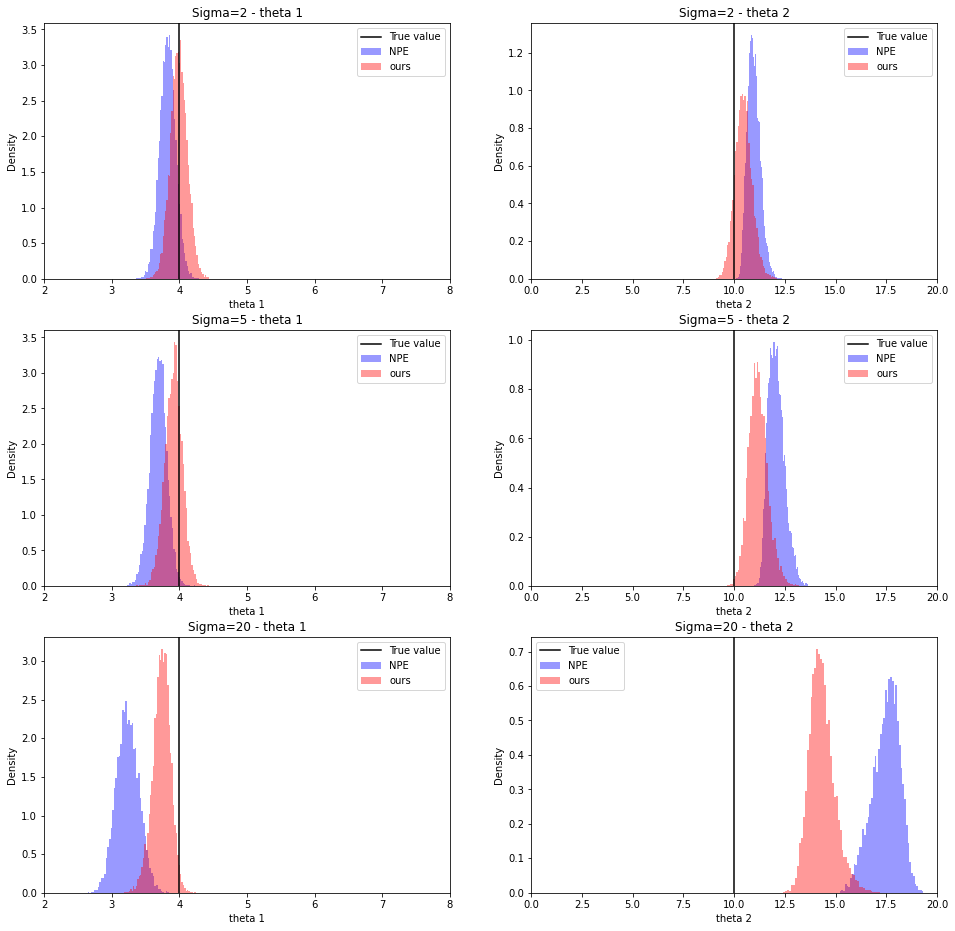

In [40]:
theta_gt = torch.tensor([4, 10])
sigma = [2, 5, 20]

plt.figure(figsize=(16,16))

root_name = "objects/magnitude_degree=0.5_var=15_obs_minimize_beta=1/0"

obs = ricker(theta_gt).to(device)
obs_cont = magnitude_sigma(obs, var=sigma[0])

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
# post_samples_rnpe = read_rnpe(misspecified=sigma[0], seed=4)

plt.subplot(3, 2, 1)
plt.xlim(2, 8)
plt.axvline(x=theta_gt[0],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
# sns.distplot(post_samples_rnpe[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Sigma={sigma} - theta 1".format(sigma=sigma[0]))
plt.legend()

plt.subplot(3, 2, 2)
plt.xlim(0, 20)
plt.axvline(x=theta_gt[1],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
# sns.distplot(post_samples_rnpe[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 2")
plt.title("Sigma={sigma} - theta 2".format(sigma=sigma[0]))
plt.legend()


obs_cont = magnitude_sigma(obs, var=sigma[1])

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
# post_samples_rnpe = read_rnpe(misspecified=sigma[1], seed=1)

plt.subplot(3, 2, 3)
plt.xlim(2, 8)
plt.axvline(x=theta_gt[0],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
# sns.distplot(post_samples_rnpe[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Sigma={sigma} - theta 1".format(sigma=sigma[1]))
plt.legend()

plt.subplot(3, 2, 4)
plt.xlim(0, 20)
plt.axvline(x=theta_gt[1],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
# sns.distplot(post_samples_rnpe[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 2")
plt.title("Sigma={sigma} - theta 2".format(sigma=sigma[1]))
plt.legend()


obs_cont = magnitude_sigma(obs, var=sigma[2])

sum_net_robust, _, posterior_robust = load_models("robust", root_name, device)
sum_net_normal, _, posterior_normal = load_models("normal", root_name, device)
post_samples_normal = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
post_samples_robust = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 100))
# post_samples_rnpe = read_rnpe(misspecified=sigma[2], seed=2)

plt.subplot(3, 2, 5)
plt.xlim(2, 8)
plt.axvline(x=theta_gt[0],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
# sns.distplot(post_samples_rnpe[:, 0], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 1")
plt.title("Sigma={sigma} - theta 1".format(sigma=sigma[2]))

plt.legend()

plt.subplot(3, 2, 6)
plt.xlim(0, 20)
plt.axvline(x=theta_gt[1],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="NPE")
# sns.distplot(post_samples_rnpe[:, 1], color='green', kde=False, norm_hist=True, label="RNPE")
sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color="red", kde=False, norm_hist=True, label="ours")
plt.ylabel("Density")
plt.xlabel("theta 2")
plt.title("Sigma={sigma} - theta 2".format(sigma=sigma[2]))

plt.legend()

# plt.savefig("posterior_ricker.pdf")
plt.show()